# Bag of Words Text Classification

In this tutorial we will show how to build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on IMDB movie reviews dataset.

This notebook is adapted from https://github.com/scoutbee/pytorch-nlp-notebooks/blob/develop/1_BoW_text_classification.ipynb


## Concepts covered in this tutorial
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. How to build a simple linear classifier using PyTorch
4. Training the model and the balance of Under-fitting v.s. Over-fitting
5. BoW and TF-IDF text classifier

In [9]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
import random
import re  # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.display import display, HTML
# from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook  # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()
print("torch.get_default_device()", torch.get_default_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print("torch.get_default_device()", torch.get_default_device())

torch.get_default_device() cuda:0
torch.get_default_device() cuda:0


In [10]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

**Take a look at a few examples**

In [13]:
df = pd.read_csv(DATA_PATH)
df.sample(5)

,review,label
48123,"As in Amelie, recent French films seem to be t...",1
55031,"I watched the movie \The Flock\"" because of th...",0
29197,"Hilarious, laugh out loud moments ... and yet ...",0
6846,And now for another point of view: I didn't li...,0
28483,"Patricia Hunter: Oh, professor, do you also ma...",0


In [15]:
print('Number of records:', len(df), '\n')
print('Number of positive reviews:', len(df[df.label == 1]))
print('Number of negative reviews:', len(df[df.label == 0]), '\n')

print('Example negative review:')
print(df.loc[55].review, '\n')
print('Example positive review:')
print(df.loc[12361].review, '\n')

Number of records: 62155 

Number of positive reviews: 30870
Number of negative reviews: 31285 

Example negative review:
Seeing this film for the first time twenty years after its release I don't quite get it. Why has this been such a huge hit in 1986? Its amateurishness drips from every scene. The jokes are lame and predictable. The sex scenes are exploitative and over the top (that is not to say that Miss Rudnik does not have nice boobs!). The singing is "schrecklich". The only genuinely funny scene is the big shoot out when the gangsters die break dancing, a trait that dates the movie firmly to the mid-eighties. It's really quite puzzling to me how incapable I am to grasp what evoked the enthusiasm of the cheering audiences in 1986 (and apparently still today, reading my fellow IMDBers comments). 

Example positive review:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton

## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below I constructed a test corpus which composed of 3 reviews. Each review is a paragraph.**

In [17]:
test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?
The 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.'''
test_corpus

'The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?\nThe 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.'

In [19]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^\w\s]', '', test_corpus)
clean_corpus = clean_corpus.lower()
clean_corpus

'the intel core i5 processor that comes with the dell latitude 5490 is quadcore and offers 16ghz and a 6m cache the base configuration includes 1 x 4gb of ddr4 noncc memory but this can be upgraded to 8gb or even 16gb 2 x 8gb if you require more memory how great is that\nthe 14inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution both versions are nontouch wlan capable and come with antiglare technology you also get a builtin camera and microphone for wireless technology the system comes with a qualcomm qca61 x 4a 80211 ac 22 wireless adapter'

In [21]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)
print(len(clean_tokens))

['the', 'intel', 'core', 'i5', 'processor', 'that', 'comes', 'with', 'the', 'dell', 'latitude', '5490', 'is', 'quadcore', 'and', 'offers', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'includes', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgraded', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'is', 'that', 'the', '14inch', 'display', 'is', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'versions', 'are', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'comes', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']
107


In [22]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)
print(len(clean_tokens))

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '5490', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']
107


In [23]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)
print(len(clean_tokens))

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '<NUM>', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '<NUM>', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '<NUM>', 'x', '<NUM>', 'or', '<NUM>', 'x', '<NUM>', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']
107


In [24]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)
print(len(clean_tokens))

['intel', 'core', 'i5', 'processor', 'come', 'dell', 'latitude', '<NUM>', 'quadcore', 'offer', '16ghz', '6m', 'cache', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'ddr4', 'noncc', 'memory', 'upgrade', '8gb', 'even', '16gb', '<NUM>', 'x', '8gb', 'require', 'memory', 'great', '14inch', 'display', 'available', 'choice', '<NUM>', 'x', '<NUM>', '<NUM>', 'x', '<NUM>', 'resolution', 'version', 'nontouch', 'wlan', 'capable', 'come', 'antiglare', 'technology', 'also', 'get', 'builtin', 'camera', 'microphone', 'wireless', 'technology', 'system', 'come', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']
68


In [29]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab


print(build_vocab([clean_tokens]))

{'intel': 0, 'core': 1, 'i5': 2, 'processor': 3, 'come': 4, 'dell': 5, 'latitude': 6, '<NUM>': 7, 'quadcore': 8, 'offer': 9, '16ghz': 10, '6m': 11, 'cache': 12, 'base': 13, 'configuration': 14, 'include': 15, 'x': 16, '4gb': 17, 'ddr4': 18, 'noncc': 19, 'memory': 20, 'upgrade': 21, '8gb': 22, 'even': 23, '16gb': 24, 'require': 25, 'great': 26, '14inch': 27, 'display': 28, 'available': 29, 'choice': 30, 'resolution': 31, 'version': 32, 'nontouch': 33, 'wlan': 34, 'capable': 35, 'antiglare': 36, 'technology': 37, 'also': 38, 'get': 39, 'builtin': 40, 'camera': 41, 'microphone': 42, 'wireless': 43, 'system': 44, 'qualcomm': 45, 'qca61': 46, '4a': 47, 'ac': 48, 'adapter': 49}


In [30]:
def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token


print(build_index2token(build_vocab([clean_tokens])))

{0: 'intel', 1: 'core', 2: 'i5', 3: 'processor', 4: 'come', 5: 'dell', 6: 'latitude', 7: '<NUM>', 8: 'quadcore', 9: 'offer', 10: '16ghz', 11: '6m', 12: 'cache', 13: 'base', 14: 'configuration', 15: 'include', 16: 'x', 17: '4gb', 18: 'ddr4', 19: 'noncc', 20: 'memory', 21: 'upgrade', 22: '8gb', 23: 'even', 24: '16gb', 25: 'require', 26: 'great', 27: '14inch', 28: 'display', 29: 'available', 30: 'choice', 31: 'resolution', 32: 'version', 33: 'nontouch', 34: 'wlan', 35: 'capable', 36: 'antiglare', 37: 'technology', 38: 'also', 39: 'get', 40: 'builtin', 41: 'camera', 42: 'microphone', 43: 'wireless', 44: 'system', 45: 'qualcomm', 46: 'qca61', 47: '4a', 48: 'ac', 49: 'adapter'}


**Bag of Words**



**TF-IDF**



**Let's pacakage the pre-processing steps together into functions and apply on our dataset**

In [31]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]


def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]


def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text)  # remove special characters
    text = text.lower()  # lowercase
    tokens = wordpunct_tokenize(text)  # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens]  # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    return tokens


def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [32]:
# Set parameters

MAX_LEN = 128  #@param [64, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000  #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [33]:
class ImdbDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000, max_len=128):
        df = pd.read_csv(data_path)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.review.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # Build most common tokens bound by max vocab size
        common_tokens = set(
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0]
        )

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]

        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

In [34]:
dataset = ImdbDataset(DATA_PATH, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 62154/62154 [00:01<00:00, 42143.96it/s]


See a random sample out of the dataset processed

In [75]:
print('Number of records:', len(dataset), '\n')

import random

random_idx = random.randint(0, len(dataset) - 1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('BoW vector first 10:', bow_vector[:10], '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('TF-IDF vector first 10:', tfidf_vector[:10], '\n')
print('Sentiment:', sample_target, '\n')
print(dataset.idx2token[1])

Number of records: 62154 

index: 25484 

There are so many incorrect statements in this so-called "documentary" that I found myself shouting at the television.<br /><br />Bart Sibrel might be able to produce a flashy looking DVD, but he is sadly lacking at looking at the science behind his claims.<br /><br />He relies on either being inaccurate, not telling the full story, or the old favourite "government always lies to us" innuendos, and people believing what is told to them and not checking on the accuracy or details behind the claims.<br /><br />What's more, his "exclusive" or "unreleased" footage is freely available over the internet from various sites.<br /><br />Further reading about the circumstances regarding the filming of this production shows that he used false pretenses to gain interviews, and has used creative editing of the responses in order to promote his own opinions.<br /><br />All of the claims made by Mr Sibrel about "inaccuracies", "mistakes", or "whistleblowing" 

## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [197]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    generator = torch.Generator(device=device).manual_seed(
        42)  # Create a generator with a fixed seed for reproducibility
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length], generator=generator
    )

In [198]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(55940, 3107, 3107)

In [199]:
BATCH_SIZE = 128


def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch]).to(device)
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [200]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader) - 1)
example_idx = random.randint(0, BATCH_SIZE - 1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')


number of training batches: 438 

Training input sequence: [73, 1, 799, 515, 1, 1, 1, 735, 1, 393, 749, 453, 963, 1, 525, 814, 941, 1, 934, 116, 1, 378, 1, 733, 583, 1, 1, 1, 1, 1, 1, 934, 934, 934, 393, 733, 583, 963, 513, 1, 496, 782, 242, 1, 1, 165, 71, 1, 393, 383, 1, 1, 108, 41, 303, 393, 1, 779, 54, 941, 73, 902, 1, 1, 1, 934, 934, 934, 934, 393, 1, 1, 809, 779, 561, 378, 941, 941, 902, 1, 108, 936, 821, 231, 286, 948, 1, 338, 513, 1] 

BoW vector size: 990 

TF-IDF vector size: 990 

Label:  tensor(0, device='cuda:0') 

Review text: Bad, ambient sound. Lots of shuffling. Loooong pointless scenes. Eg: guy sees interesting woman in lobby. Manages to stay there and watch her under the guise of waiting for the building supervisor to get a package. Says nothing. Stares creepily. More shuffling and other irritating ambient noise. Wait. Wait. Wait. Guy says nothing. Woman looks frightened or at least slightly disturbed about it and rightly so. Manager comes back with package. Guy goes 

## BoW Model

### Build BoW Linear Model

- Input: BoW Vector
- Model:
    - linear mapping of bow vector to logits
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [97]:
class LinearTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(LinearTextClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_labels)

    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        return torch.softmax(self.fc(x), dim=-1)


P.S. You can also add layers or reduce layers by modifying the cell below

In [98]:
bow_model = LinearTextClassifier(
    vocab_size=len(dataset.token2idx),
    num_labels=2,
)
bow_model

LinearTextClassifier(
  (fc): Linear(in_features=990, out_features=2, bias=True)
)

In [99]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([2, 990])
torch.Size([2])


### Train BoW Model




affine scoring: $$logits = \theta X + b$$
output: $$p = softmax(logits)$$
Loss: $$L = −y_0 log(p_0)-y_1 log(p_1)$$
Gradient:
$$\frac{\partial }{\partial \theta}L(\theta, b) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial logits}\frac{\partial logits}{\partial  \theta}$$

Parameter update:
$$ \theta =  \theta - \alpha \frac{\partial }{\partial \theta}L(\theta, b)$$

**Define the initial learning rate**

What happens if you set a very small learning rate? What if you set a very large learning rate?

In [100]:
LEARNING_RATE = 5e-4

**Define loss function and gradient descent optimizer**

- Criterion: compute *Loss* to see how much does prediction differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily are global minimum reached.
- scheduler: dynamic alter the learning rate

When selecting optimizers, you can think about what problems can we run into when performing gradient desent? (hint: global minimum v.s. local minimum)

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round**

In [102]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    inputs = ''
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    inputs = ''
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

** Run training epochs**

In [103]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 1.24e-03	valid_loss: 1.21e-03

epoch #  2	train_loss: 1.15e-03	valid_loss: 1.13e-03

epoch #  3	train_loss: 1.09e-03	valid_loss: 1.09e-03

epoch #  4	train_loss: 1.05e-03	valid_loss: 1.05e-03

epoch #  5	train_loss: 1.02e-03	valid_loss: 1.03e-03

epoch #  6	train_loss: 1.00e-03	valid_loss: 1.01e-03

epoch #  7	train_loss: 9.84e-04	valid_loss: 9.94e-04

epoch #  8	train_loss: 9.71e-04	valid_loss: 9.82e-04

epoch #  9	train_loss: 9.60e-04	valid_loss: 9.72e-04

epoch # 10	train_loss: 9.50e-04	valid_loss: 9.63e-04

epoch # 11	train_loss: 9.42e-04	valid_loss: 9.56e-04

epoch # 12	train_loss: 9.35e-04	valid_loss: 9.49e-04

epoch # 13	train_loss: 9.28e-04	valid_loss: 9.43e-04

epoch # 14	train_loss: 9.23e-04	valid_loss: 9.38e-04

epoch # 15	train_loss: 9.18e-04	valid_loss: 9.34e-04

epoch # 16	train_loss: 9.13e-04	valid_loss: 9.30e-04

epoch # 17	train_loss: 9.09e-04	valid_loss: 9.26e-04

epoch # 18	train_loss: 9.05e-04	valid_loss: 9.22e-04

epoch # 19	train_loss: 9.02e

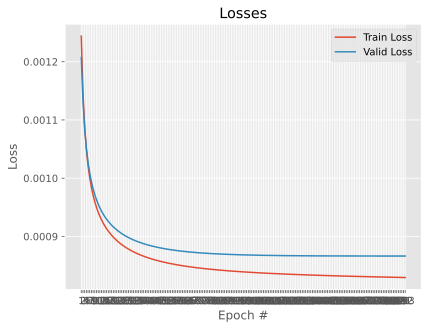

In [104]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### Check Performance of BoW Model

In [107]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)

        probs = probs.detach().cpu()  #.numpy()
        predictions = torch.argmax(probs, dim=1)
        target = target.cpu()  #.numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1562
           1       0.85      0.86      0.85      1545

    accuracy                           0.85      3107
   macro avg       0.85      0.85      0.85      3107
weighted avg       0.85      0.85      0.85      3107



**Let's check a few examples**

In [112]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))


def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            if input_type == 'tdidf':
                inputs = tdidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{i + 1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [114]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,"One of the commenter's is wrong. This is not the only Pat Patterson film and he didn't die two years after this was made. He shot a film called the ""Electric Chair"" in Pineville, NC. He shot this a few years after Doctor Gore. Patterson died in the late 70's. I know this because he used my house and he left a cat there!! It sucked also. This was a big deal when the movie came out. No independent horror films were being made in NC. This movie didn't help matters. Patterson used to do gore effects for H. G. Lewis. He was also good at magic. His gore scenes in Body shop were actually well done. The film was shot in a building that also housed a 7/11. You can actually see the tops of the walls in some scenes. The budget was less that $20,000 and the script looked like a child wrote it. Only Patterson could understand it. Still...it's entertainment and it's a classic.",😡,😡
2,"I's a big struggle. As a story that is surreal, this movie could've been great (as great as it is rated by some here), but mixed with the acting (director and relatives playing major roles, due to financial reasons I reckon) found in here ... although calling this acting, is not only a stretch of that word, it's giving it a new meaning! A whole new meaning! If you are into surreal movies (there are some that I do like actually, see the Japanese Strange Circus for example), you might be able to overlook the flaws (see above) and enjoy this more. There are great ideas here, after all! Many great metaphors and ambiguous scenes, but while watching this (with a group of friends) almost all of us, just couldn't stop laughing ... not the intention of the director of course! Again, everyone has their own liking, as one can see by the high rating of this movie, but I could only recommend the movie if you're aware of the work that Alejandro Jodorowsky has done and/or are a fan of his!",😄,😡
3,"Billy Crystal co-wrote, co-produced and stars in this extremely safe and comfy comedy-drama about fathers and sons, adult irresponsibility, and growing old. Billy plays a heart surgeon who has a heart attack (ha ha) which causes him to seek out his estranged father (Alan King), a movie-extra who fancies himself a big star. The script is sub-Neil Simon nonsense with one-liners galore, a flat, inexpressive direction by Henry Winkler (stuck in sitcom mode), and family-conflict at the ready. Crystal and King try their best, but King is over-eager and frequently over-the-top. JoBeth Williams has another one of her thankless roles, but manages to bring her innate, down-home class to the proverbial girlfriend character. It's a comedy, I guess, but one that blinks back the tears...shamefully. ** from ****",😡,😡
4,"I saw this movie not knowing anything about it before hand. The plot was terrible with large gaps of information missing. The movie didn't have the ""battle of wits"" feel to me. The actors just spewed out mouthful's of nonsense, at times causing me to gnash my teeth in agony as they droned on and on. The plot was predictable except for the stomach sickening homo erotic scene at the end (I'm not homophobic but made me physically sick to my stomach), even the ending was predictable. And you could tell the detective was Jude Law in a costume, everything from the fake accent, terrible dental work, costume shop facial hair, everything pointed to it being a disguise. The whole movie just felt like wasted time out of my life. This movie had the feel of a puppet show with Jude Law and Michael Caine as puppets and the house as the window to view the show, really boooring in my opinion.",😡,😡
5,"I like the film, itÂ´s the best pirate-movie I watched hitherto (forget silly Errol-Flynn-stuff and Pirates of the Caribbean). This movie is wonderful melancholic. I compare it with ""Johnny Guitar"" at the sea-side (but 3 years earlier), two women fighting for a man, where mad love might lead one.The character of the female (anti-) heroine, Anne Providence, is su

## TF-IDF Model

**Term Frequency - Inverse Document Frequency**

For a term `i` in document `j`:

$$TFIDF = TF_{i,j} \times log \frac{N}{DF_i}$$

- TF: number of occurance of the term `i` in document `j`
- N: total number of documents
- DF: number of documents containins the term `i`

Questions:
- Why would this be more representative than pure bag of words?
- What does TFIDF score of a word mean for a document?

### Initialize TF-IDF Model

In [134]:
tfidf_model = LinearTextClassifier(
    vocab_size=len(dataset.token2idx),
    num_labels=2,
)
tfidf_model

LinearTextClassifier(
  (fc): Linear(in_features=990, out_features=2, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [135]:
LEARNING_RATE = 5e-5

In [136]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [137]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 1.31e-03	valid_loss: 1.34e-03

epoch #  2	train_loss: 1.31e-03	valid_loss: 1.34e-03

epoch #  3	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  4	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  5	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  6	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  7	train_loss: 1.30e-03	valid_loss: 1.33e-03

epoch #  8	train_loss: 1.30e-03	valid_loss: 1.33e-03

epoch #  9	train_loss: 1.30e-03	valid_loss: 1.33e-03

epoch # 10	train_loss: 1.30e-03	valid_loss: 1.33e-03

epoch # 11	train_loss: 1.30e-03	valid_loss: 1.32e-03

epoch # 12	train_loss: 1.30e-03	valid_loss: 1.32e-03

epoch # 13	train_loss: 1.30e-03	valid_loss: 1.32e-03

epoch # 14	train_loss: 1.30e-03	valid_loss: 1.32e-03

epoch # 15	train_loss: 1.29e-03	valid_loss: 1.32e-03

epoch # 16	train_loss: 1.29e-03	valid_loss: 1.32e-03

epoch # 17	train_loss: 1.29e-03	valid_loss: 1.32e-03

epoch # 18	train_loss: 1.29e-03	valid_loss: 1.31e-03

epoch # 19	train_loss: 1.29e

KeyboardInterrupt: 

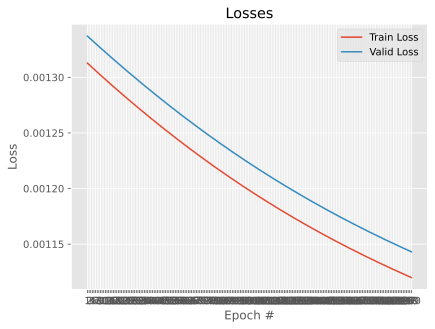

In [138]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### TF-IDF Performance

In [139]:
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1486
           1       0.83      0.79      0.81      1621

    accuracy                           0.80      3107
   macro avg       0.80      0.81      0.80      3107
weighted avg       0.81      0.80      0.80      3107



In [121]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

## Quiz 1: Build your own Neural Logistic Regression Text Classifier


- Input: BoW vector or TF-IDF vector
- 2 Affine layer (what are the dimensions of input and output?)
- 1 Softmax activation

In [239]:
# Define hidden layer size and training parameter
HIDDEN1 = 250  # @param ["10","30","50","100","200","500"] {"type":"raw","allow-input":true}
HIDDEN2 = 50  #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
DROPOUT_PUB = 0.5
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4

In [240]:
## define your feedforward neural networks:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, vocab_size, HIDDEN1, HIDDEN2, num_labels, dropout_pub=0.5):  # pass layer dimension
        super(FeedfowardTextClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, HIDDEN1)  # First hidden layer
        self.fc2 = nn.Linear(HIDDEN1, HIDDEN2)  # second hidden layer
        self.fc3 = nn.Linear(HIDDEN2, num_labels)  # Output layer
        self.dropout = nn.Dropout(dropout_pub)
        ## add layers

    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        x = F.relu(self.fc1(x))  # First layer + activation function
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Second layer + activation function
        x = self.dropout(x)
        return torch.softmax(self.fc3(x), dim=-1)  # softmax output
        ## pass through affine layer & activation

In [241]:
neural_model = FeedfowardTextClassifier(
    ## your code here
    vocab_size=len(dataset.token2idx),
    HIDDEN1=HIDDEN1,
    HIDDEN2=HIDDEN2,
    num_labels=2,
    dropout_pub=DROPOUT_PUB,
)
neural_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=990, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [242]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, neural_model.parameters()),
    lr=LEARNING_RATE,  #try add weight_decay
    weight_decay=WEIGHT_DECAY,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [243]:
## Run training & validation
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(neural_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(neural_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-4:]):
        print('Stopping early')
        break

    if n_epochs > 200:
        print('Enough training')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 4.51e-03	valid_loss: 3.74e-03

epoch #  2	train_loss: 3.62e-03	valid_loss: 3.65e-03

epoch #  3	train_loss: 3.55e-03	valid_loss: 3.64e-03

epoch #  4	train_loss: 3.51e-03	valid_loss: 3.63e-03

epoch #  5	train_loss: 3.49e-03	valid_loss: 3.64e-03

epoch #  6	train_loss: 3.48e-03	valid_loss: 3.64e-03

epoch #  7	train_loss: 3.47e-03	valid_loss: 3.64e-03

epoch #  8	train_loss: 3.46e-03	valid_loss: 3.63e-03

epoch #  9	train_loss: 3.45e-03	valid_loss: 3.63e-03

epoch # 10	train_loss: 3.44e-03	valid_loss: 3.64e-03

epoch # 11	train_loss: 3.43e-03	valid_loss: 3.64e-03

epoch # 12	train_loss: 3.42e-03	valid_loss: 3.63e-03

epoch # 13	train_loss: 3.41e-03	valid_loss: 3.62e-03

epoch # 14	train_loss: 3.39e-03	valid_loss: 3.61e-03

epoch # 15	train_loss: 3.37e-03	valid_loss: 3.61e-03

epoch # 16	train_loss: 3.35e-03	valid_loss: 3.60e-03

epoch # 17	train_loss: 3.33e-03	valid_loss: 3.59e-03

epoch # 18	train_loss: 3.31e-03	valid_loss: 3.58e-03

epoch # 19	train_loss: 3.29e

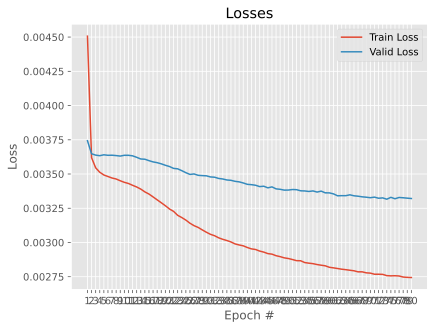

In [244]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [245]:
## Run model evaluation
## Please Report Your Final best F1 score in LM and Submit Your Notebook
neural_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = neural_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1579
           1       0.89      0.91      0.90      1528

    accuracy                           0.90      3107
   macro avg       0.90      0.90      0.90      3107
weighted avg       0.90      0.90      0.90      3107



In [246]:
print_random_prediction(neural_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,"on this quagmire of mediocrity? You are SO much better than this.Simply put, Frostbite is worthless. Bad acting (and I use that term loosely), minimalist ""plot,"" sophomoric humor, and lackluster snowboarding. There's not even a sufficient display of feminine pulchritude to spark the prurient interest of socially inept, but red-blooded, males.Top Gun had spectacular flight sequences to goggle at. Days of Thunder had heart-pounding racing action. Even Point Break had skydiving scenes to its credit. Frostbite has none of these. It's not worth your time, my time, Traci Lords' time, Carmen Nicole's time, nor the time of anyone involved with this destruction of celluloid that would have been perfectly usable on something worthwhile had it not been wasted on this fodder for the recycling center.The world will be a better place when we forget that Frostbite ever existed.",😡,😡
2,"Seriously. If this had been the first Shack movie, it would have been passable as funny, silly and goofy. Light satire commentary on the class system would make this an enjoyable late-night rental.However, everyone wants to compare it to the first film, and maybe that's not fair. The first film is a cult classic; what could possibly follow it up? Nothing. So take this second film as a stand alone, and it certainly has its moments.Jackie Mason is amusing, doing his best Rodney-wannabe impersonation. Is he as good as Rodney? No. Are his lines as good? No. But he is funny. The rest of the cast falls in line as being decent, but not outstanding. You'll recognize faces amongst the cast and wonder how they got to where they are today.The film is predictable, but aren't most in this genre? Again, it's not the best comedy you'll see, but if you like Cannonball Run-type fun, you'll enjoy this one.",😄,😄
3,"It's easy to make really general comments about a film like this. The fact that it's one of the only remaining Japanese films from this era causes people to say that it \started Japanese cinema\"" and was \""unlike anything the west ever made.\"" The latter of these two comments is particularly false as Kinugasa himself admitted to ripping off \""Caligari\"" on more than one occasion. But style was meant to be imitated, and doesn't take away from this film's importance. What we have here is experimental themes and composition built on already established visual styles, opening the doors for a truly brilliant layering of narratives and realities. For this purpose, the madhouse is the ideal setting, and the writers knew this. This is a landmark film, and every effort should be made to track it down.5 out of 5 - Essential""",😄,😄
4,"There will be a time where kids will have grown up without ever seeing the one and only Bugs Bunny kiss (technically) another man on the lips. There will be a time where it won't be Duck or Rabbit season. There will be a time where the Tazmanian Devil will be dubbed politically incorrect.But so help me now is not that time.Nobody really wants an 'EXTREME' version of our beloved Loony characters. Whoever it is in marketing who comes up with ""Corn Nuts: Corn gone wrong"" and ""Extreme Doritos"" and evidently this festering turd should know that just because they have a degree in business or advertising or whatever doesn't mean they know jack about kids.I think that they're doing a disservice to children, depriving them of one of the greatest and most iconic shows of all time. This show disgusts me, and it's not just the dated artwork or terrible dialogue. They misuse good voice talent, like Phil Lamarr, Michael Clarke Duncan, Candi Milo, and so many others. It lacks style, humor, character development, and most importantly, heart.The show, like it's repackaged characters (Slam Tasmanian, Rev Runner, Ace Bunny) is but a shadow of it's former, timeless and beautiful self.",😄,😡
5,"I've just visited Russian forum of our TV-channel that had showed this film. Well... 99 per cent of active Russian audience is disapp

# Quiz 2: BoW Naive Bayes
If the feature vectors are binary indicator, is it true that all naive Bayes classifier can be represented by another feature based linear classifier?

More formally, for $\phi(x)\in \{0,1\}^d$ and a dataset D=$\{(x_i,y_i)\}_{i=1}^n$. Can we get a set of linear scores $\{\theta_y \}_y$ and a feature vector $\phi'$ such that $\hat{P}_{naive\_bayes,\phi}(y|x)= \frac{\exp (\langle \theta_y,\phi'(x)\rangle)}{\sum_{y'} \exp (\langle \theta_{y'},\phi'(x)\rangle)}$ ?

Recall that $\hat{P}_{naive\_bayes,\phi}(y|x)= \frac{\hat{P}_{mle}(y)         \prod_i\hat{P}_{mle}(\phi_i(x)|y)}{\sum_{y'} \hat{P}_{mle}(y)\prod_i\hat{P}_{mle}(\phi_i(x)|y')}$ where the estimator is from the dataset.